In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

##### 1. Data Acquisition:

In [4]:
# Download historical data for Nifty IT Index
nifty_it = yf.download('^CNXIT', start='2010-01-01', end='2024-11-10', interval='1d')
nifty_it = nifty_it[['Close']].fillna(method='ffill')

nifty_it.tail()


[*********************100%%**********************]  1 of 1 completed


c:\ProgramData\anaconda3\envs\deeptrend\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\Krunal Shambharkar\AppData\Local\Temp\ipykernel_32612\3359415196.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_it = nifty_it[['Close']].fillna(method='ffill')


,Close
Date,
2024-11-04,40421.800781
2024-11-05,40424.601562
2024-11-06,42039.500000
2024-11-07,41752.398438
2024-11-08,42050.148438


In [5]:
nifty_it.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3358 entries, 2010-01-04 to 2024-11-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3358 non-null   float64
dtypes: float64(1)
memory usage: 52.5 KB


##### 2. EDA and Feturing Engineering 

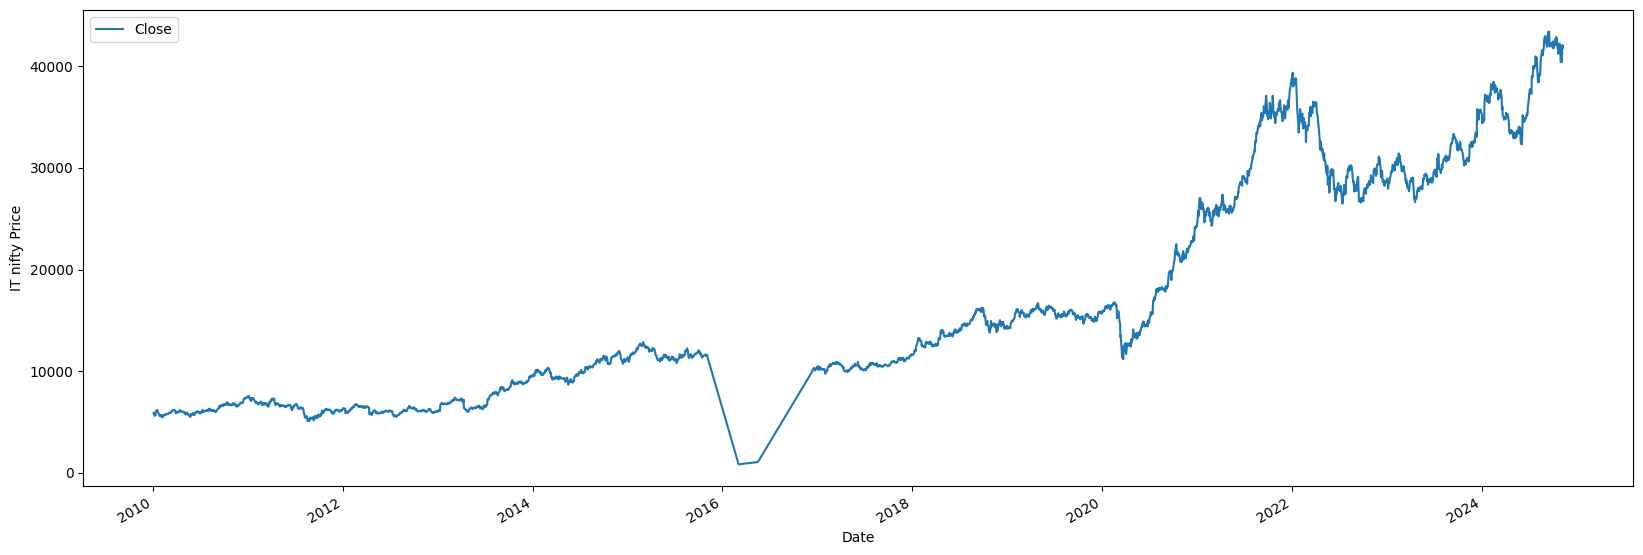

In [6]:
nifty_it.plot(figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('IT nifty Price')
plt.show()

visualizing the trends

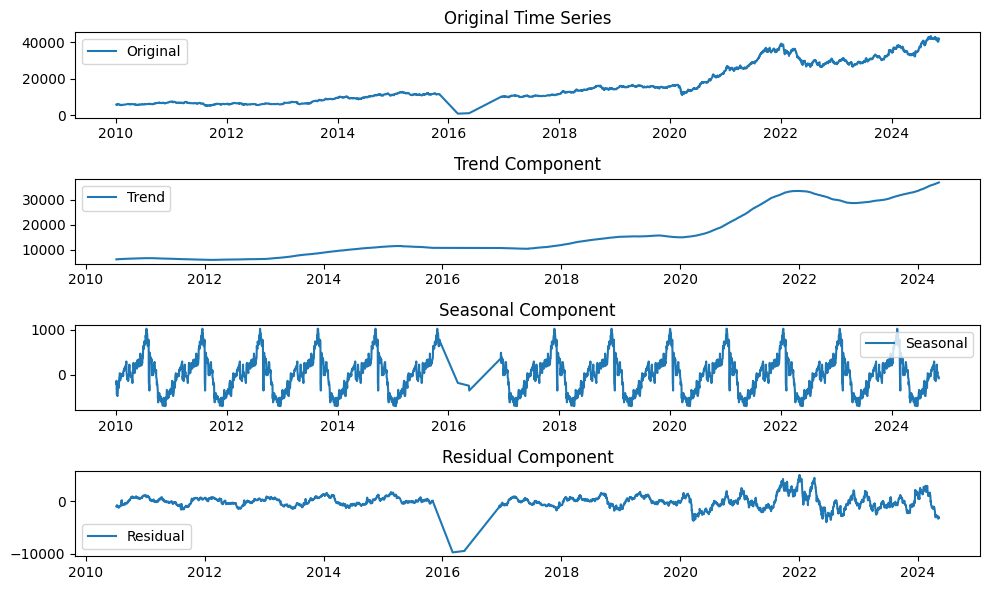

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition on the data
results = seasonal_decompose(nifty_it['Close'], model='additive', period=253)

# Plot the original, trend, seasonal, and residual components
plt.figure(figsize=(10, 6))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(nifty_it['Close'], label='Original')
plt.legend()
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(results.trend, label='Trend')
plt.legend()
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(results.resid, label='Residual')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()


**4. Train-Test Split and Scaling**

In [8]:
# Train-test split
train_size = int(len(nifty_it) * 0.8)
train, test = nifty_it.iloc[:train_size], nifty_it.iloc[train_size:]


In [9]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(nifty_it)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**5. Data Preparation for LSTM**

In [10]:
# Reshape data for LSTM
def create_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i + n_input])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

In [11]:
n_input = 3
X_train, y_train = create_sequences(scaled_train, n_input)
X_test, y_test = create_sequences(scaled_test, n_input)

**6. Building the LSTM Model**

In [12]:
# Build the LSTM model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(n_input, 1)))
model.add(Dropout(0.2))

In [13]:
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.2))

In [14]:
model.add(GRU(units=64))
model.add(Dropout(0.1))

In [15]:
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

**7. Training the Model**

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
84/84 [==============================] - 5s 5ms/step - loss: 0.0493
Epoch 2/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 3/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 4/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 5/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 6/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 7/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 8/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0151
Epoch 9/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 10/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 11/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 12/20
84/84 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 13/20
84/84 [==============================

**8. Plotting Training Loss**

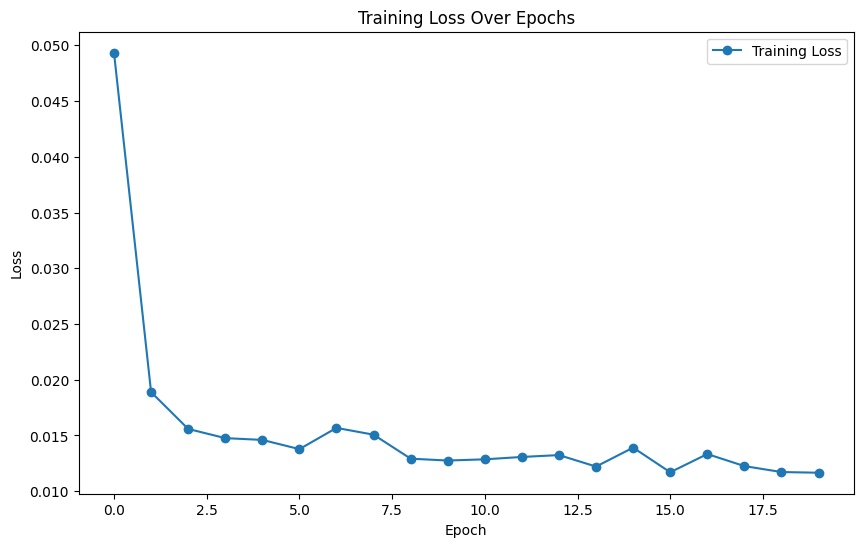

In [17]:
# Extract training loss from the history
train_loss_history = history.history['loss']

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 5. Model Evaluation : Making Predictions and Plotting Results**

In [18]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


21/21 [==============================] - 0s 1ms/step


In [19]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training MSE: {train_loss}')
print(f'Testing MSE: {test_loss}')

Training MSE: 0.00642727455124259
Testing MSE: 0.011820616200566292


In [20]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Calculate MAE, MSE, MAPE for training set
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

train_mse = mean_squared_error(y_train, train_predict)

print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.4f}%')
print(f'Training MSE: {train_mse:.4f}')

# Calculate MSE


Training MAE: 273.7054
Training MAPE: 3.4774%
Training MSE: 222698.3528


In [22]:
# Calculate MAE, MSE, MAPE for testing set
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
mse_test = mean_squared_error(y_test, test_predict)

print(f'Testing MAE: {test_mae:.4f}')
print(f'Testing MAPE: {test_mape:.4f}%')
print(f'Testing MSE: {train_mse:.4f}')

Testing MAE: 503.3808
Testing MAPE: 1.5779%
Testing MSE: 222698.3528


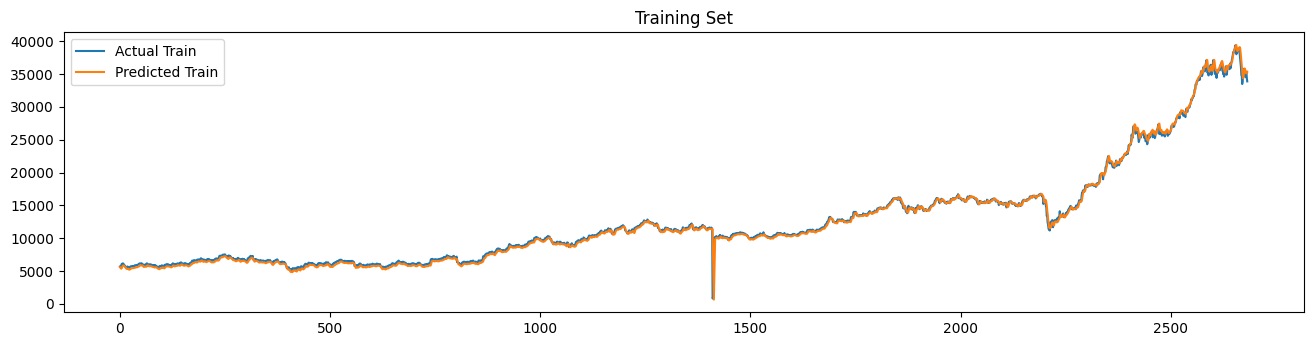

In [23]:
# Plot predictions
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(y_train, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')

plt.title('Training Set')
plt.legend()

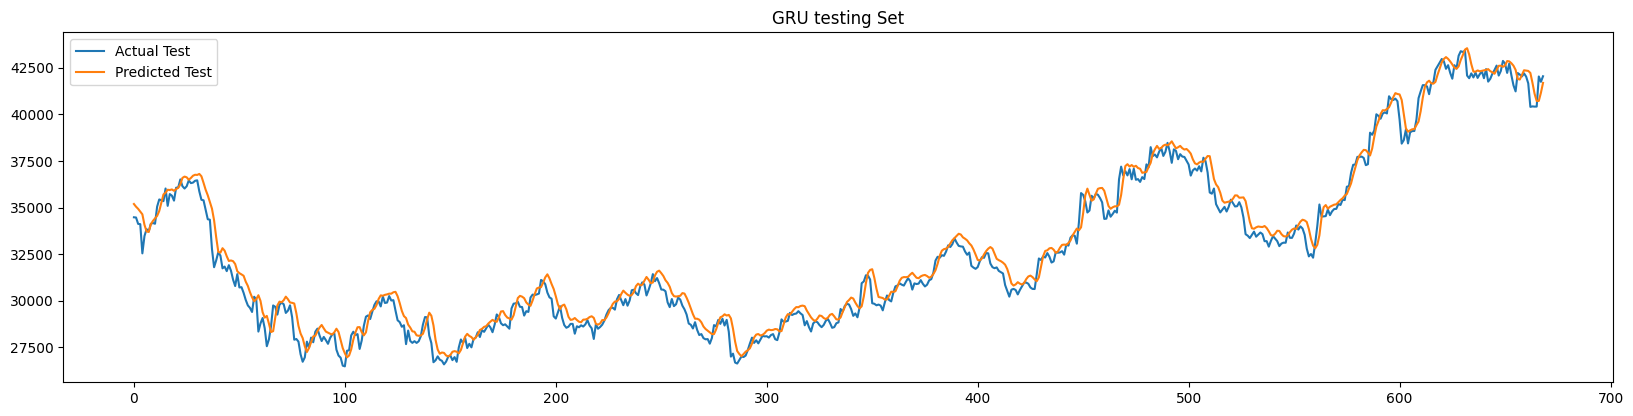

In [24]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.title('GRU testing Set')
plt.legend()

plt.show()